<Axes: >

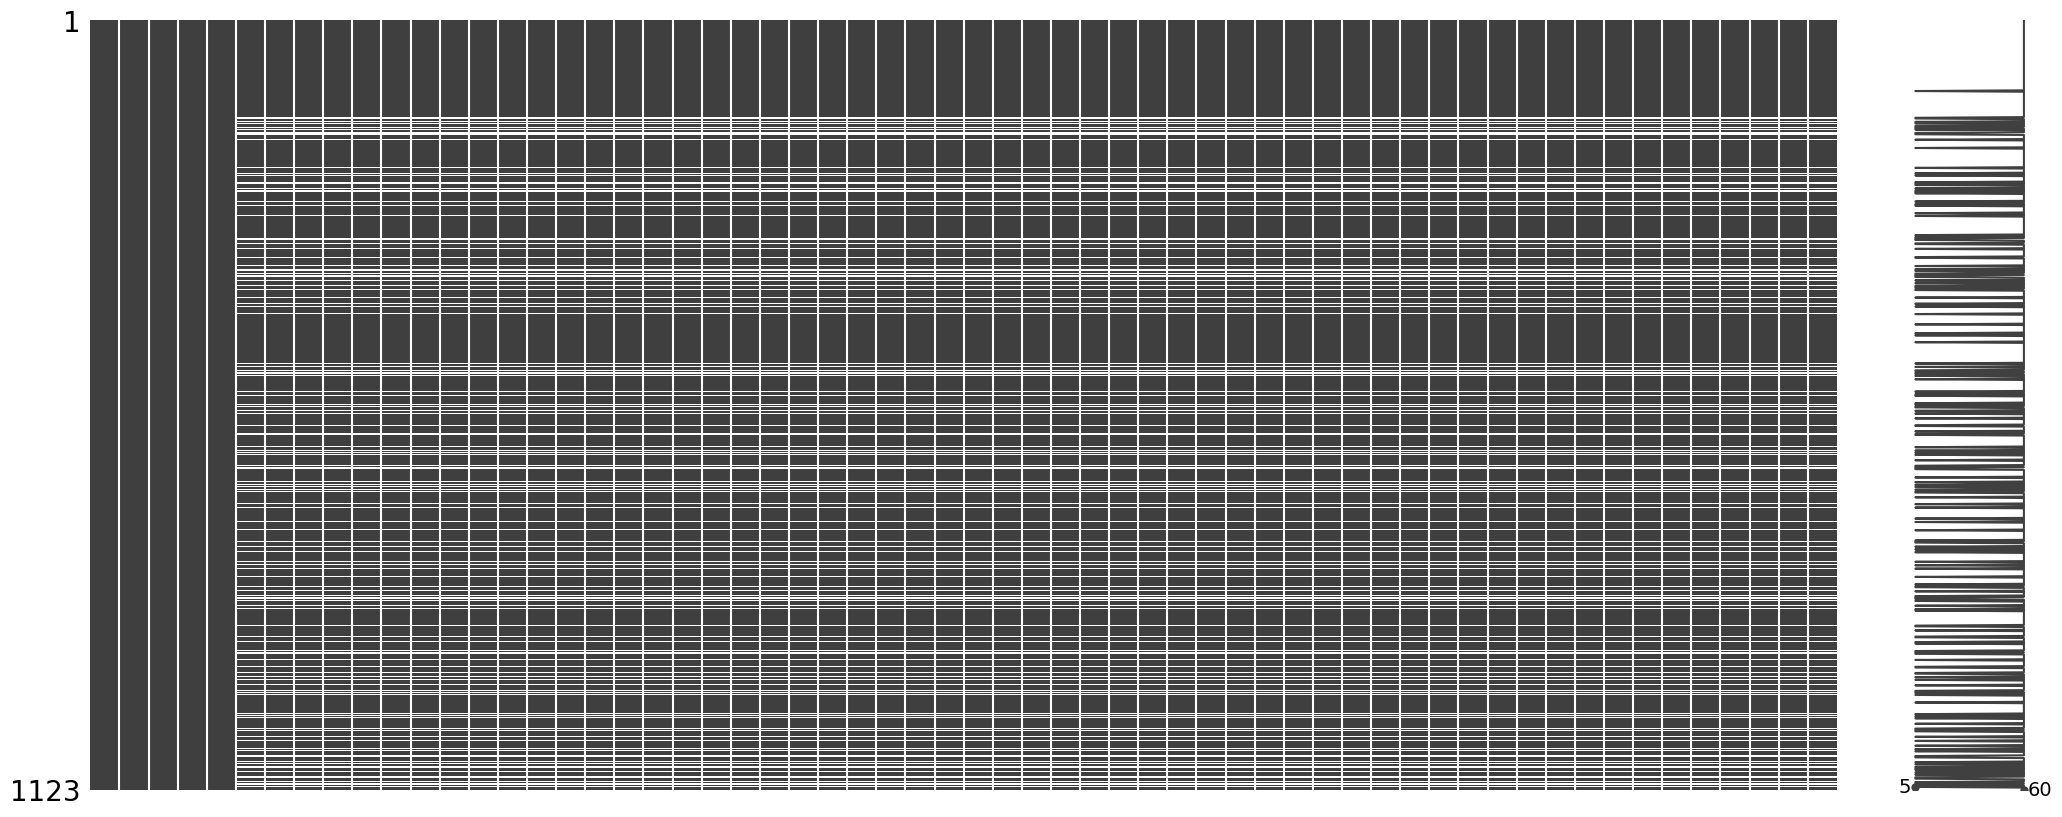

In [14]:
import pandas as pd
import missingno as msgn
from sodapy import Socrata
import requests
import time

def get_municipios():
    """
    Function to get the municipios from the API

    Returns
    -------
    Municipios:
        pd.DataFrame: DataFrame with the municipios
    """
    client = Socrata("www.datos.gov.co", None)
    results = client.get("xdk5-pm3f", limit=2000)
    for result in results:
        if len(result["c_digo_dane_del_municipio"]) < 6:
            result["c_digo_dane_del_municipio"] = "0" + result["c_digo_dane_del_municipio"]
            if len(result["c_digo_dane_del_municipio"]) < 6:
                result["c_digo_dane_del_municipio"] = result["c_digo_dane_del_municipio"]+"0"
                if len(result["c_digo_dane_del_municipio"]) < 6:
                    result["c_digo_dane_del_municipio"] = result["c_digo_dane_del_municipio"]+"0"
        result["c_digo_dane_del_municipio"] = result["c_digo_dane_del_municipio"].replace(".", "")
    results_df = pd.DataFrame.from_records(results)

    # check if all the c_digo_dane_del_municipio have 5 digits
    for index, row in results_df.iterrows():
        if len(row['c_digo_dane_del_municipio']) != 5:
            print(f'Error: {row["c_digo_dane_del_municipio"]} has {len(row["c_digo_dane_del_municipio"])} digits')
    return results_df

def get_search_query(municipios: pd.DataFrame)->pd.DataFrame:
    """
    Function to get the search query from the municipios dataframe
    and makes a new dataframe with the search query as follows:
    `municipio, departamento, pais`

    Parameters
    ----------
    municipios : pd.DataFrame
        DataFrame with the municipios
            columns: ['municipio', 'departamento'], pais is 'Colombia'
    
    Returns
    -------
    search_query:
        pd.DataFrame: DataFrame with the search query
            columns: ['search_query']
    """
    search_query = pd.DataFrame()
    for index, row in municipios.iterrows():
        # - Dibula, La Guajira, Colombia -> Dibulla, La Guajira, Colombia
        # - Tolú Viejo, Sucre, Colombia -> Tolúviejo, Sucre, Colombia
        # - San Juan de Río Seco, Cundinamarca, Colombia -> San Juan de Ríoseco, Cundinamarca, Colombia
        # - San Luis de Gaceno, Casanare, Colombia -> San Luis de Gaceno, <a style='color:red'> Boyacá </a>, Colombia
        # > **Nota:** Se Obta por San Luis de Gaceno, Boyacá, Colombia, dado que San Luis de Gaceno, Casanare, Colombia no se encuentra, y San Luis de Gaceno, Boyacá, Colombia es el municipio más cercano.
        # - Villa de San Diego de Ubate, Cundinamarca, Colombia -> Ubaté, Provincia de Ubaté, Colombia
        # - El Cantón del San Pablo, Chocó, Colombia -> El Cantón de San Pablo, Chocó, Colombia
        # - Valle de Guamez, Putumayo, Colombia -> Valle Del Guamuez, Putumayo, Colombia
        # - San Pablo de Borbur, Bolívar, Colombia -> San Pablo de Borbur, Boyaca, Colombia o San Pablo, Bolívar, Colombia
        # > **Nota:** Se Obta por San Pablo, Bolívar, Colombia, dado que San Pablo de Borbur, Boyaca, Colombia ya se encuentra en la base de datos.
        # - San Andrés de Tumaco, Nariño, Colombia -> Tumaco, Nariño, Colombia

        if f'{row["municipio"]}, {row["departamento"]}, Colombia' == 'Dibula, La Guajira, Colombia':
            search_query = pd.concat([search_query, pd.DataFrame({'search_query': 'Dibulla, La Guajira, Colombia'}, index=[0])])
        elif f'{row["municipio"]}, {row["departamento"]}, Colombia' == 'Tolú Viejo, Sucre, Colombia':
            search_query = pd.concat([search_query, pd.DataFrame({'search_query': 'Tolúviejo, Sucre, Colombia'}, index=[0])])
        elif f'{row["municipio"]}, {row["departamento"]}, Colombia' == 'San Juan de Río Seco, Cundinamarca, Colombia':
            search_query = pd.concat([search_query, pd.DataFrame({'search_query': 'San Juan de Ríoseco, Cundinamarca, Colombia'}, index=[0])])
        elif f'{row["municipio"]}, {row["departamento"]}, Colombia' == 'San Luis de Gaceno, Casanare, Colombia':
            search_query = pd.concat([search_query, pd.DataFrame({'search_query': 'San Luis de Gaceno, Boyacá, Colombia'}, index=[0])])
        elif f'{row["municipio"]}, {row["departamento"]}, Colombia' == 'Villa de San Diego de Ubate, Cundinamarca, Colombia':
            search_query = pd.concat([search_query, pd.DataFrame({'search_query': 'Ubaté, Provincia de Ubaté, Colombia'}, index=[0])])
        elif f'{row["municipio"]}, {row["departamento"]}, Colombia' == 'El Cantón del San Pablo, Chocó, Colombia':
            search_query = pd.concat([search_query, pd.DataFrame({'search_query': 'El Cantón de San Pablo, Chocó, Colombia'}, index=[0])])
        elif f'{row["municipio"]}, {row["departamento"]}, Colombia' == 'Valle de Guamez, Putumayo, Colombia':
            search_query = pd.concat([search_query, pd.DataFrame({'search_query': 'Valle Del Guamuez, Putumayo, Colombia'}, index=[0])])
        elif f'{row["municipio"]}, {row["departamento"]}, Colombia' == 'San Pablo de Borbur, Bolívar, Colombia':
            search_query = pd.concat([search_query, pd.DataFrame({'search_query': 'San Pablo, Bolívar, Colombia'}, index=[0])])
        elif f'{row["municipio"]}, {row["departamento"]}, Colombia' == 'San Andrés de Tumaco, Nariño, Colombia':
            search_query = pd.concat([search_query, pd.DataFrame({'search_query': 'Tumaco, Nariño, Colombia'}, index=[0])])
        else:
            search_query = pd.concat([search_query, pd.DataFrame({'search_query': f'{row["municipio"]}, {row["departamento"]}, Colombia'}, index=[0])])

    search_query.reset_index(drop=True, inplace=True)    
    return search_query

def get_location_info(search_query: pd.DataFrame)->pd.DataFrame:
    """
    Function that gets all the information from the api 
    https://nominatim.openstreetmap.org/search.php?q={search_query}&format=jsonv2
    and returns a dataframe with the information
    """
    
    location_info = pd.DataFrame()
    for index, row in search_query.iterrows():
        #start_time = time.time()
        url = f'https://nominatim.openstreetmap.org/search.php?q={row["search_query"]}&format=jsonv2'
        response = requests.get(url)
        # get only the first result
        try:
            response_json = response.json()[0]
            print(f'Getting info from {index+1}/{len(search_query)} {row["search_query"]}')
            print(response_json)
        except:
            print(f'Error with {row["search_query"]}')
            continue
        # print the length of the response
        print(len(response_json))
        # add the info to the dataframe keep boundingbox as a list
        response_json['boundingbox'] = [response_json['boundingbox']]
        location_info = pd.concat([location_info, pd.DataFrame(response_json, index=[0])])
        # print the time
        #print("--- %s seconds ---" % (time.time() - start_time))
    return location_info

def get_distance_and_time_matrix(origins_info: pd.DataFrame, destinations_info: pd.DataFrame)->pd.DataFrame:
    """
    Function to get the distance and time matrix from the coordinates
    uses the OSRM API to obtain the values, and has a limit, that for 
    safety is set to 100x100, if the size is bigger, if the size is bigger
    use the function get_distance_and_time_matrix_full_size()
    
    Parameters
    --------
    origins_info : pd.DataFrame
        DataFrame with the origins info
            columns: ['name', 'lat', 'lon']

    destinations_info : pd.DataFrame
        DataFrame with the destinations info
            columns: ['name', 'lat', 'lon']
            
    Returns
    -------
    distance_matrix:
        pd.DataFrame: DataFrame with the distance matrix
        
    time_matrix:
        pd.DataFrame: DataFrame with the time matrix

    Examples
    --------

    >>> origins_info = pd.DataFrame({'name': ['Bogotá', 'Medellín', 'Cali'], 'lat': [4.60971, 6.25184, 3.43722], 'lon': [-74.08175, -75.56359, -76.5225]})
    >>> destinations_info = pd.DataFrame({'name': ['Barraquilla', 'Cartagena', 'Bucaramanga'], 'lat': [10.96389, 10.39972, 7.12539], 'lon': [-74.79639, -75.51444, -73.1198]})
    >>> distance_matrix, time_matrix = get_distance_and_time_matrix_v2(origins_info, destinations_info)
    >>> display(distance_matrix)

    |    | name        |   Barraquilla |   Cartagena |   Bucaramanga |
    |---:|:------------|--------------:|------------:|--------------:|
    |  0 | Bogotá      |       1145.79 |     1059.79 |        396.06 |
    |  1 | Medellín    |       1014.61 |      928.61 |        264.88 |
    |  2 | Cali        |       1045.02 |      959.02 |        295.29 |

    >>> display(time_matrix)

    |    | name        |   Barraquilla |   Cartagena |   Bucaramanga |
    |---:|:------------|--------------:|------------:|--------------:|
    |  0 | Bogotá      |        15.55  |       14.35 |          5.35 |
    |  1 | Medellín    |        13.8   |       12.6  |          4.5  |
    |  2 | Cali        |        14.45  |       13.25 |          5.15 |

    distances in meters
    times in seconds
    """
    url_base = 'http://router.project-osrm.org/table/v1/driving/'
    #/table/v1/{profile}/{coordinates}?{sources}=[{elem}...];&{destinations}=[{elem}...]&annotations={duration|distance|duration,distance}
    url_origins = ''
    for index, municipio in origins_info.iterrows():
        # get the coordinates
        lon = municipio['lon']
        lat = municipio['lat']
        coordinates = f'{lon},{lat};'
        url_origins += coordinates
    url_destinations = ''
    for index, municipio in destinations_info.iterrows():
        # get the coordinates
        lon = municipio['lon']
        lat = municipio['lat']
        coordinates = f'{lon},{lat};'
        url_destinations += coordinates
    # remove the last ;
    url_destinations = url_destinations[:-1]

    sources = ''
    for i in range(len(origins_info)):
        sources += f'{i};'
    # remove the last ;
    sources = sources[:-1]

    destinations = ''
    for i in range(len(destinations_info)):
        destinations += f'{i+len(origins_info)};'
    # remove the last ;
    destinations = destinations[:-1]

    # create the url
    url = url_base + url_origins + url_destinations +'?sources=' + sources + '&destinations=' + destinations + '&annotations=distance,duration'
    
    response = requests.get(url)
    # check if the response is ok
    if response.status_code != 200:
        print(f'Error: {response.status_code}')
        return None, None
    # get the distance and time matrix
    response_json = response.json()
    distance_matrix = pd.DataFrame(response_json['distances'], index=origins_info['name'], columns=destinations_info['name'])
    time_matrix = pd.DataFrame(response_json['durations'], index=origins_info['name'], columns=destinations_info['name'])
    return distance_matrix, time_matrix

def get_distance_and_time_matrix_full_size(origins_info: pd.DataFrame, destinations_info):
    """
    # TODO: #6 add docstring
    """
    #get_distance_and_time_matrix() only allows size 100x100
    #this function splits the data in chunks of 100x100 and then merges the results

    #get the number of chunks
    num_chunks = int(len(origins_info)/100)
    if len(origins_info)%100 != 0:
        num_chunks += 1

    #split the data in chunks
    origins_info_chunks = []
    destinations_info_chunks = []
    for i in range(num_chunks):
        origins_info_chunks.append(origins_info[i*100:(i+1)*100])
        destinations_info_chunks.append(destinations_info[i*100:(i+1)*100])

    #get the distance and time matrix for each chunk
    distance_matrix_chunks = []
    time_matrix_chunks = []
    for i in range(num_chunks):
        for j in range(num_chunks):
            print(f'Getting chunk {i*num_chunks+j+1}/{num_chunks*num_chunks}')
            distance_matrix, time_matrix = get_distance_and_time_matrix(origins_info_chunks[i], destinations_info_chunks[j])

            #append the results
            distance_matrix_chunks.append(distance_matrix)
            time_matrix_chunks.append(time_matrix)
    # save to csv
    # for i in range(num_chunks):
    #     for j in range(num_chunks):
    #         distance_matrix_chunks[i*num_chunks+j].to_csv(f'matrix/distance_matrix/{i*num_chunks+j}.csv')
    #         time_matrix_chunks[i*num_chunks+j].to_csv(f'matrix/time_matrix/{i*num_chunks+j}.csv')
    # merge the chunks
    distance_matrix = pd.DataFrame()
    time_matrix = pd.DataFrame()
    # add horizontally and vertically the chunks
    for i in range(num_chunks):
        row_distance = pd.DataFrame()
        row_time = pd.DataFrame()
        for j in range(num_chunks):
            row_distance = pd.concat([row_distance, distance_matrix_chunks[i*num_chunks+j]], axis=1)
            row_time = pd.concat([row_time, time_matrix_chunks[i*num_chunks+j]], axis=1)
        distance_matrix = pd.concat([distance_matrix, row_distance], axis=0)
        time_matrix = pd.concat([time_matrix, row_time], axis=0)
    # force the diagonal to be 0
    for i in range(len(distance_matrix)):
        distance_matrix.iloc[i,i] = 0
        time_matrix.iloc[i,i] = 0
    # save to csv
    # distance_matrix.to_csv('distance_matrix.csv')
    # time_matrix.to_csv('time_matrix.csv')
    return distance_matrix, time_matrix

def get_poblacion()->pd.DataFrame:
    """
    Obtiene de los archivos
        aior\test\data\poblacion_por_municipios\DCD-area-proypoblacion-Mun-1985-1994 (1).xlsx
        aior\test\data\poblacion_por_municipios\DCD-area-proypoblacion-Mun-1995-2004 (2).xlsx
        aior\test\data\poblacion_por_municipios\DCD-area-proypoblacion-Mun-2005-2019 (2).xlsx
        aior\test\data\poblacion_por_municipios\DCD-area-proypoblacion-Mun-2020-2035-ActPostCOVID-19 (2).xlsx
    los datos de población por municipio y año.

    Returns
    -------
    DataFrame
        DataFrame con los datos de población por municipio y año.
    """
    
    # Carga de datos
    df_1985_1994 = pd.read_excel('poblacion_por_municipios\\DCD-area-proypoblacion-Mun-1985-1994 (1).xlsx')
    df_1995_2004 = pd.read_excel('poblacion_por_municipios\\DCD-area-proypoblacion-Mun-1995-2004 (2).xlsx')
    df_2005_2019 = pd.read_excel('poblacion_por_municipios\\DCD-area-proypoblacion-Mun-2005-2019 (2).xlsx')
    # TODO: #7 Anotar que en este archivo 2005-2019 hay un error en las columnas, se debe cambiar dpmp y mpio de lugar
    df_2020_2035 = pd.read_excel('poblacion_por_municipios\\DCD-area-proypoblacion-Mun-2020-2035-ActPostCOVID-19 (2).xlsx')
    # Concatenación de los datos
    df = pd.concat([df_1985_1994, df_1995_2004, df_2005_2019, df_2020_2035], ignore_index=True)
    # turn column names into lowercase
    df.columns = df.columns.str.lower()
    # Turn area uniques into columns for the same dp and dpmp and año
    df = df.pivot_table(index=['dp', 'dpnom', 'dpmp', 'mpio', 'año'], columns='área geográfica', values='población').reset_index()
    df.columns = df.columns.str.lower()
    # turn dpmp values into string
    df['dpmp'] = df['dpmp'].astype(str)
    df['dpmp'] = df['dpmp'].apply(lambda x: "0" + x if len(x) != 5 else x)
    # all dpmp with '94343' must have a 'mpio' of 'Barrancominas'ArithmeticError
    df.loc[df['dpmp'] == '94343', 'mpio'] = 'Barrancominas'
    
    # TODO: #9 Anotar que existe el caso especial de Barranco Minas

    return df

def pivot_per_municipio(df:pd.DataFrame)->pd.DataFrame:
    # TODO: #8 Hacer el docstring
    cabecera = df.pivot_table(index=['dp', 'dpnom', 'dpmp', 'mpio'], columns='año', values='cabecera municipal').reset_index()
    centros_poblados = df.pivot_table(index=['dp', 'dpnom', 'dpmp', 'mpio'], columns='año', values='centros poblados y rural disperso').reset_index()
    total = df.pivot_table(index=['dp', 'dpnom', 'dpmp', 'mpio'], columns='año', values='total').reset_index()
    return total, cabecera, centros_poblados

municipios = get_municipios()
poblacion = get_poblacion()
total, cabecera, centros_poblados = pivot_per_municipio(poblacion)
# merge the dataframes

municipios = pd.merge(municipios, total, how='left', left_on=['c_digo_dane_del_municipio'], right_on=['dpmp'])
municipios.to_csv('municipios_con_poblacion.csv')


In [8]:

# TODO: #3 Matriz de Distancias
# TODO: #4 Matriz de Tiempos
# TODO: #5 Merge Habitantes

# TODO: #6 Merge Demanda
# TODO: #7 Merge Origenes